# Investigate the Quality of Flower102

In [1]:
# install needed libaries
#!pip install torch==2.0.0 torchvision scienceplots einops torchinfo randomname seaborn -q

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
import sys

sys.path.append("../")

from src.cleaner.selfclean import PretrainingType, SelfClean

In [3]:
dataset_splits = []
for split in ["train", "val", "test"]:
    dataset_splits.append(datasets.Flowers102(root="./data", download=True, split=split))
dataset = torch.utils.data.ConcatDataset(dataset_splits)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344862509/344862509 [00:12<00:00, 28127380.11it/s]


Extracting tmp/flowers-102/102flowers.tgz to tmp/flowers-102


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1298914.63it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14989/14989 [00:00<00:00, 40956627.14it/s]


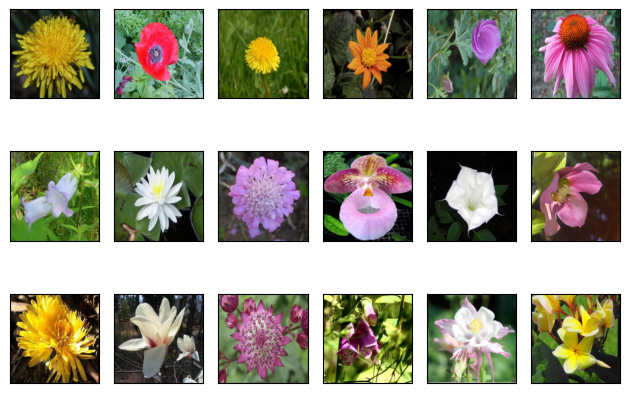

In [4]:
fig, axes = plt.subplots(3, 6)
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        index = np.random.randint(0, high=len(dataset))
        ax.imshow(transforms.Resize((256, 256))(dataset[index][0]))
        ax.set_xticks([])
        ax.set_yticks([])
        index += 1
fig.tight_layout()
plt.show()

Will run the code on one GPU.
STARTUP | distributed init (rank 0): env://
Running on: cuda
Run directory of model: /home/fabian/Documents/_git/GitHub/digital-dermatology/SelfClean/examples/DINO-Flowers102
Data loaded: there are 8189 train images, 512 batches, and a batch size of 16.
Found checkpoint at /tmp/tmp3wfmcgew
Found checkpoint at /tmp/tmp3wfmcgew
Found checkpoint at /tmp/tmp3wfmcgew
Found checkpoint at /tmp/tmp_62lytjq
Found checkpoint at /tmp/tmp_62lytjq
Found checkpoint at /tmp/tmp_62lytjq
Single GPU detected, model will run on single instance.
Single GPU detected, model will run on single instance.
Student and Teacher are built: they are both vit_tiny network.


Epoch: 10, Train loss: 2.706079, Train stud/teach acc: 0.0769:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9/10 [55:06<05:32, 332.51s/it]

Saving checkpoint: /home/fabian/Documents/_git/GitHub/digital-dermatology/SelfClean/examples/DINO-Flowers102/checkpoints/checkpoint-epoch10.pth ...


Epoch: 10, Train loss: 2.706079, Train stud/teach acc: 0.0769: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [55:07<00:00, 330.70s/it]

Saving current best: model_best.pth ...



Processing possible near duplicates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3353/3353 [00:34<00:00, 97.93it/s]
Processing possible irrelevant samples: 16377it [00:03, 5167.21it/s]


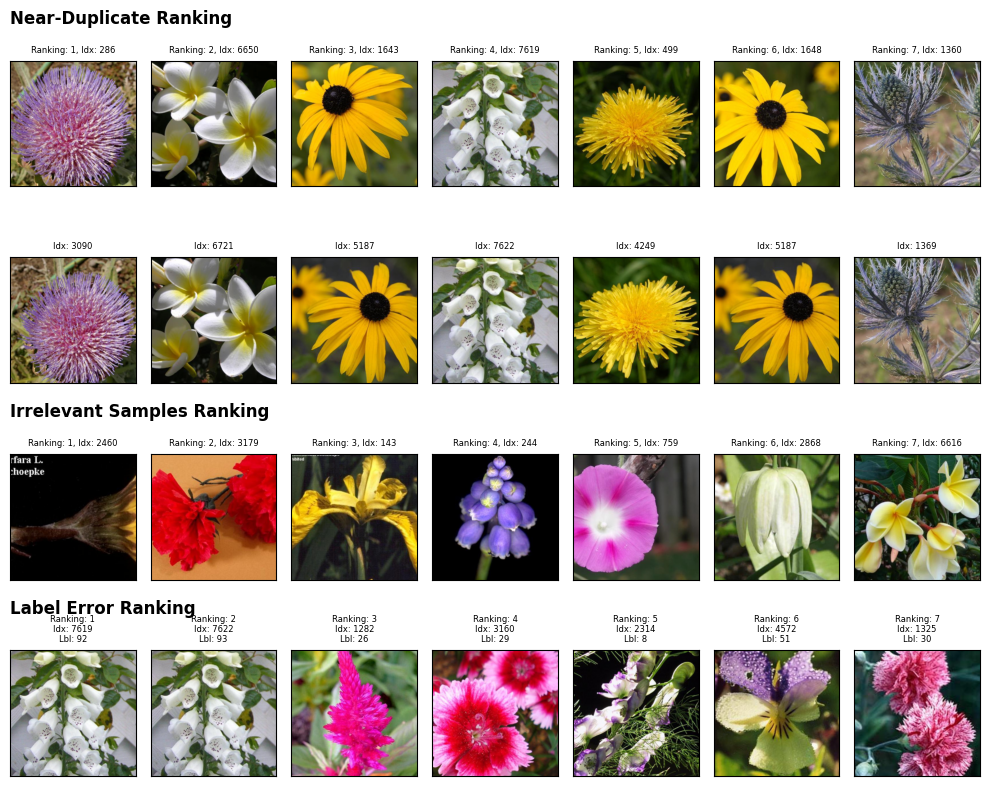

In [5]:
selfclean = SelfClean(
    plot_top_N=7,
)
out_dict = selfclean.run_on_dataset(
    dataset=copy.copy(dataset),
    pretraining_type=PretrainingType.DINO,
    num_workers=24,
    epochs=10,
    batch_size=16,
    dataset_name='Flowers102',
)

Let's look at each issue type in more detail.

In [10]:
# reset to our visualisation augmentation
for d in dataset.datasets:
    d.transform = None

### Near duplicates

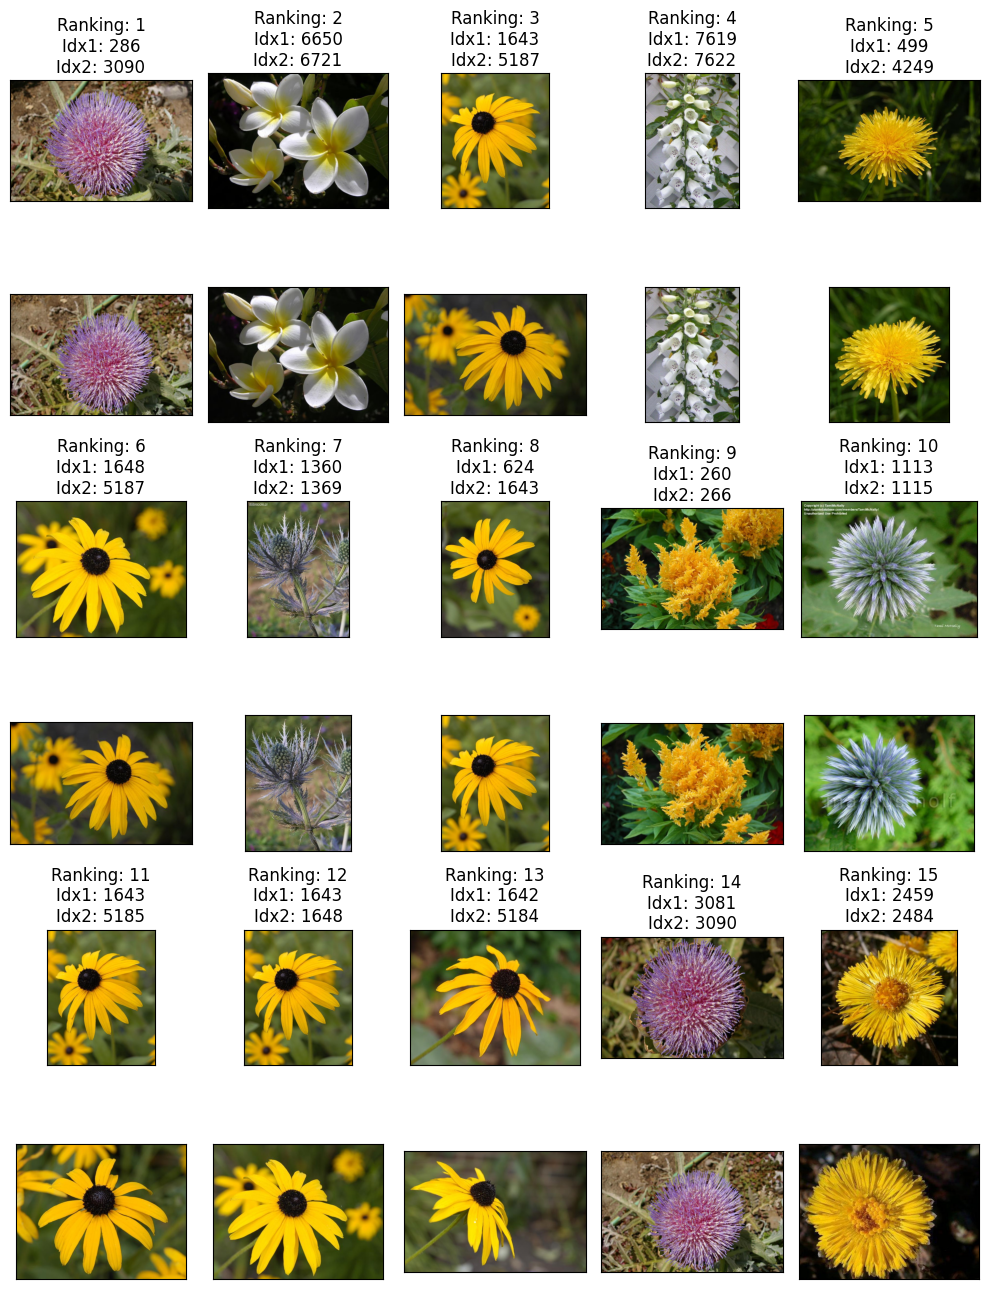

In [11]:
r_index = 0
fig, axes = plt.subplots(6, 5, figsize=(10, 13))
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        if h_idx % 2 == 1:
            continue

        idx1, idx2 = out_dict['near_duplicates']['indices'][r_index]
        idx1, idx2 = int(idx1), int(idx2)

        ax.imshow(dataset[idx1][0])
        axes[h_idx + 1, v_idx].imshow(dataset[idx2][0])
        ax.set_title(
            f"Ranking: {r_index+1}"
            f"\nIdx1: {idx1}"
            f"\nIdx2: {idx2}"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        axes[h_idx + 1, v_idx].set_xticks([])
        axes[h_idx + 1, v_idx].set_yticks([])
        r_index += 1

fig.tight_layout()
plt.show()

### Irrelevant Samples

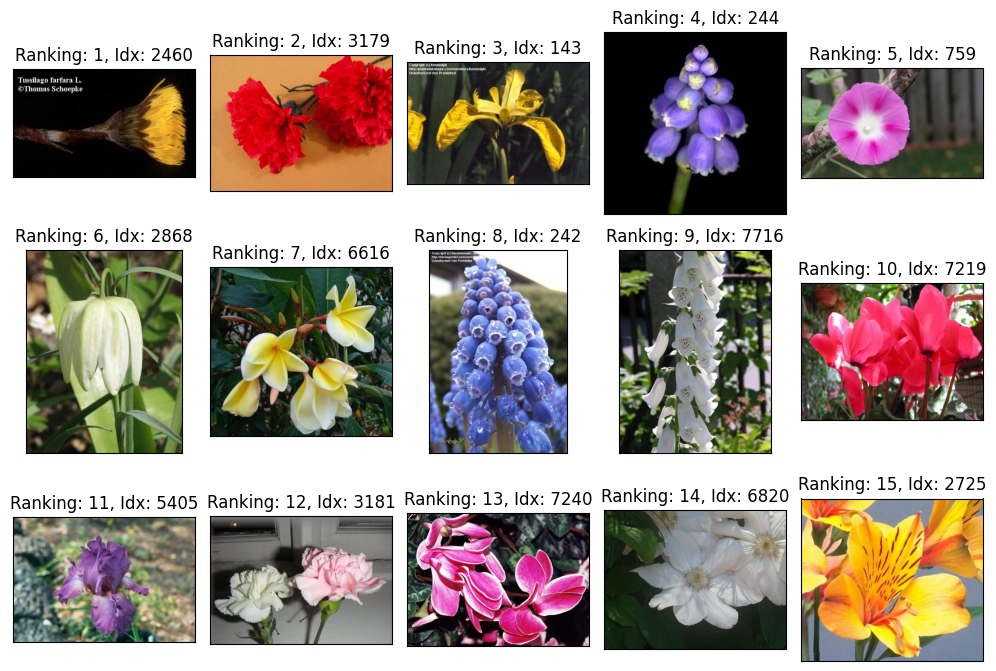

In [12]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = out_dict['irrelevants']['indices'][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(f"Ranking: {r_index+1}, Idx: {idx}")
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

### Label Errors

In [ ]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = out_dict['label_errors']['indices'][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(
            f"Ranking: {r_index+1}, Idx: {idx}"
            f"\n{dataset[idx][1]}"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()